<h1><center>Sartorius: Cell Instance Segmentation[DetectronV2]</center></h1>

<center><img src = "https://previews.123rf.com/images/spectral/spectral1402/spectral140200030/25634425-3d-illustration-von-nervenzellen-.jpg" width = "750" height = "500"/></center>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>TRAIN WITH AUGMENTATIONS</center></h2>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional

from tqdm import tqdm
import itertools

import torch, torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob

import warnings

In [2]:
# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util

setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [4]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.cuda.manual_seed_all(n)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(n)

set_random(42)

In [5]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 2070 SUPER, 470.86, 7959 MiB


# CONFS

In [6]:
data_dir = './sartorius-cell-instance-segmentation'
ROOT = Path(data_dir)

TRAIN_CSV = f"{data_dir}/train.csv"
TRAIN_PATH = f"{data_dir}/train"
TEST_PATH = f"{data_dir}/test"

# train_ann = "../input/annotations-sartorius/annotations_train.json"
# val_ann = "../input/annotations-sartorius/annotations_val.json"

train_ann = f"{data_dir}/annotations_train_poly.json"
val_ann = f"{data_dir}/annotations_val_poly.json"

LOAD_WEIGHTS = False
WORKERS = 12
BATCH_SIZE = 2

 # LOAD DATASET

In [7]:
register_coco_instances('Sartorius_train',{},train_ann, ROOT)
register_coco_instances('Sartorius_valid',{},val_ann, ROOT)
metadata = MetadataCatalog.get('Sartorius_train')

dataset_train = DatasetCatalog.get('Sartorius_train')
dataset_valid = DatasetCatalog.get('Sartorius_valid')

[12/26 19:16:34 d2.data.datasets.coco]: Loaded 545 images in COCO format from ./sartorius-cell-instance-segmentation/annotations_train_poly.json
[12/26 19:16:34 d2.data.datasets.coco]: Loaded 61 images in COCO format from ./sartorius-cell-instance-segmentation/annotations_val_poly.json


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize the data</center></h2>

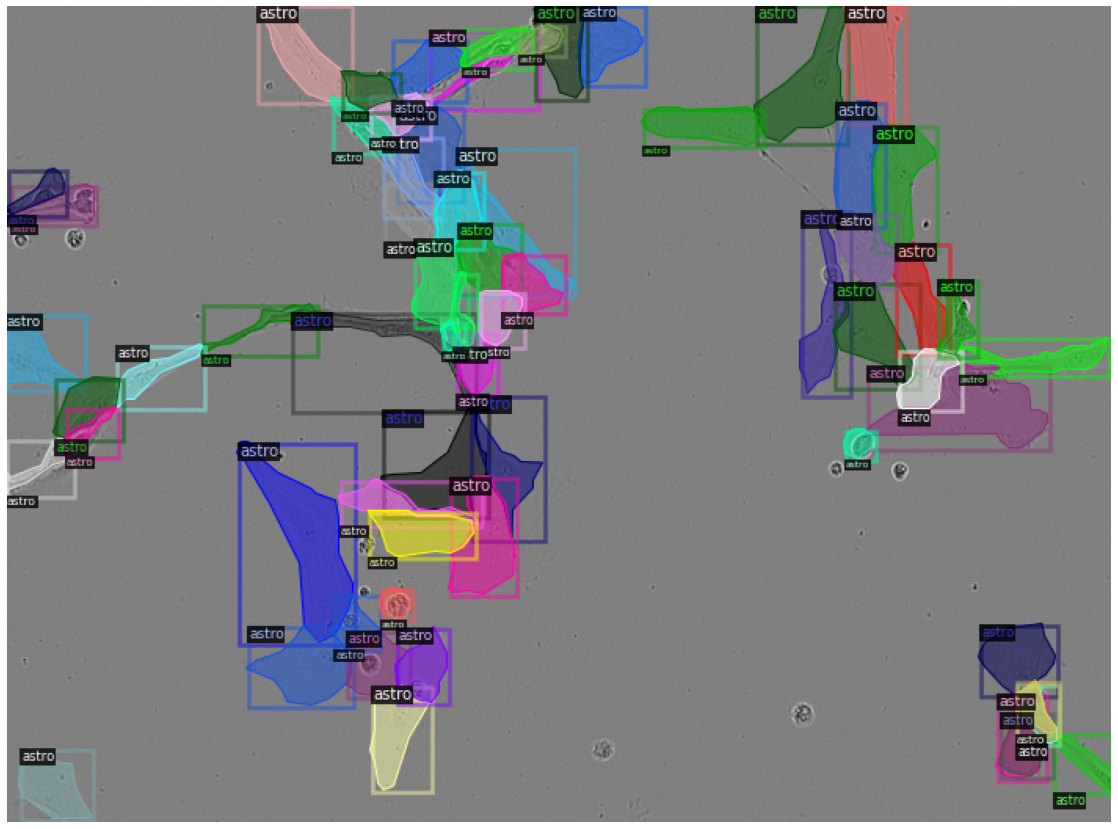

In [8]:
d =dataset_valid[11]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1],
                        metadata=metadata,
                        scale=1,
                        instance_mode=ColorMode.IMAGE_BW) # remove the colors of unsegmented pixels. This option is only available for segmentation models

out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Augmentation</center></h2>

In [ ]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict['file_name'], format='BGR')
    transform_list = [
        T.RandomBrightness(0.9, 1.1),
        T.RandomContrast(0.9, 1.1),
        T.RandomSaturation(0.9, 1.1),
        T.RandomLighting(0.9),
        T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [ ]:
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>EVALUATOR</center></h2>

Generates lines like this in the training output: [10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [20]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

In [21]:
class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}

    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

In [22]:
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

# TRAINING

In [23]:
cfg = get_cfg()
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ('Sartorius_train',)
cfg.DATASETS.TEST = ('Sartorius_valid',)

if LOAD_WEIGHTS:
    cfg.MODEL.WEIGHTS = './output/model_final.pth'
else:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = WORKERS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.BASE_LR = 0.0005

#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005
#cfg.SOLVER.GAMMA = 0.1

cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 5000 #Maximum of iterations
cfg.SOLVER.STEPS = (500, 1000) #At which point to change the LR 0.25,0.5
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('Sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
#cfg.TEST.EVAL_PERIOD = 250
cfg.SOLVER.CHECKPOINT_PERIOD = len(DatasetCatalog.get('Sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

[12/26 19:19:44 d2.data.datasets.coco]: Loaded 545 images in COCO format from ./sartorius-cell-instance-segmentation/annotations_train_poly.json
[12/26 19:19:45 d2.data.datasets.coco]: Loaded 545 images in COCO format from ./sartorius-cell-instance-segmentation/annotations_train_poly.json


In [25]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = AugTrainer(cfg) # with  data augmentation
trainer = Trainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[12/26 20:22:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[12/26 20:22:39 d2.engine.train_loop]: Starting training from iteration 0
[12/26 20:22:43 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f72b67ab1f0> to CPU due to CUDA OOM
[12/26 20:22:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f72b67ab1f0> to CPU due to CUDA OOM
[12/26 20:22:57 d2.utils.events]:  eta: 0:31:21  iter: 19  total_loss: 1.149  loss_cls: 0.3093  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 0.3637  loss_rpn_loc: 0.3286  time: 0.6699  data_time: 0.0586  lr: 0.0005  max_mem: 4684M
[12/26 20:22:58 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f72b67ab1f0> to CPU due to CUDA OOM
[12/26 20:23:02 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f72b67ab1f0> to CPU due to CUDA OOM
[12/26 20:23:06 d2.utils.events]:  eta: 0:30:57  iter: 39  total_loss: 0.4859  loss_cls: 1.058e-06  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 0.2192  loss_rpn_loc: 0.2586  time: 0.

KeyboardInterrupt: 

# EVALUATOR

For some datasets evaluation is already implemented in detectron2

For instance, many kinds of Average Precision are calculated in COCO evaluator

COCOEvaluator calculates AP with IoU from **0.50 to 0.95**

In [ ]:
evaluator = COCOEvaluator('Sartorius_valid', cfg, False, output_dir="./output/")
#cfg.MODEL.WEIGHTS="../input/detectron2cell/output/model_final.pth"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
#cfg.INPUT.MASK_FORMAT='polygon'
val_loader = build_detection_test_loader(cfg, 'Sartorius_valid')
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Plot losses</center></h2>

In [ ]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

In [ ]:


# 1. Accuracy curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

# PREDICTOR

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('Sartorius_valid')

In [ ]:
outs = []
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('Sartorius_train'),

                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('Sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])